In [1]:
%load_ext rpy2.ipython
%load_ext autotime
import rpy2.robjects.lib.ggplot2 as ggplot2
import childespy
import numpy as np
import os
import sys
import imp
import pandas as pd
import transformers
import torch
import re
import unicodedata
import scipy.stats
import copy
from string import punctuation
from pprint import pprint

R[write to console]: Installing package into ‘/home/stephan/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)



Reinstalling childesr version 0.2.1


R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/childesr_0.2.3.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 22865 bytes (22 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to conso

time: 9.5 s (started: 2022-02-14 06:30:13 -08:00)


In [2]:
%%R
# load R dependencies
library('plyr')
library('tidyr')
library('plotROC')
library('pROC')

R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following object is masked from ‘package:plotROC’:

    ggroc


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var




time: 193 ms (started: 2022-02-14 06:30:22 -08:00)


In [3]:
sys.path.append('../../')
from src.utils import sample_models_across_time, load_models, hyperparameter_utils, configuration
config = configuration.Config()

time: 162 ms (started: 2022-02-14 06:30:23 -08:00)


In [4]:
%%R
filter_model_subset = function(this_df, model_names_list){
    #return(this_df[this_df$model %in% model_names_list])
    return(subset(this_df, this_df$model %in% model_names_list))
}

sem <- function(x) sd(x)/sqrt(length(x))

time: 7.82 ms (started: 2022-02-14 06:30:23 -08:00)


# Load Scores and move to R

In [5]:
levdist_scores_across_time = pd.concat(sample_models_across_time.assemble_scores_no_order('levdist'))
# Remove 0.5 and 4.0 because they are sparse.
levdist_scores_across_time = levdist_scores_across_time[~levdist_scores_across_time.age.isin({0.5, 4.0})]
levdist_scores_across_time['likelihood_type'] = 'Levenshtein Distance'

time: 1.67 s (started: 2022-02-14 06:30:23 -08:00)


In [6]:
wfst_scores_across_time = pd.concat(sample_models_across_time.assemble_scores_no_order('wfst'))
# Remove 0.5 and 4.0 because they are sparse.
wfst_scores_across_time = wfst_scores_across_time[~wfst_scores_across_time.age.isin({0.5, 4.0})]
wfst_scores_across_time['likelihood_type'] = 'WFST'

time: 1.87 s (started: 2022-02-14 06:30:24 -08:00)


In [7]:
raw_scores_across_time = pd.concat([levdist_scores_across_time, wfst_scores_across_time])

time: 1.36 s (started: 2022-02-14 06:30:26 -08:00)


In [8]:
all_args = load_models.gen_all_model_args()

beta_set = {}
lambda_set = {}
for arg_set in all_args:
    model_title = load_models.gen_model_title(*arg_set)
    this_beta = hyperparameter_utils.get_optimal_hyperparameter_value(*arg_set, 'beta')
    beta_set[model_title] = round(this_beta, 3)
    this_lambda = hyperparameter_utils.get_optimal_hyperparameter_value(*arg_set, 'lambda')
    lambda_set[model_title] = round(this_lambda, 3)
    
pprint(beta_set)
pprint(lambda_set)

{'Adult BERT without tags, , +-20 utts context': 3.5,
 'Adult BERT without tags, , same utt only': 4.2,
 'CHILDES BERT with tags, , +-20 utts context': 3.2,
 'CHILDES BERT with tags, , same utt only': 3.2,
 'CHILDES BERT with tags, older children, +-20 utts context': 3.4,
 'CHILDES BERT with tags, older children, same utt only': 3.5,
 'CHILDES BERT with tags, younger children, +-20 utts context': 3.0,
 'CHILDES BERT with tags, younger children, same utt only': 3.1,
 'CHILDES BERT without tags, , +-20 utts context': 3.2,
 'CHILDES BERT without tags, , same utt only': 3.3,
 'CHILDES BERT without tags, older children, +-20 utts context': 3.5,
 'CHILDES BERT without tags, older children, same utt only': 3.6,
 'CHILDES BERT without tags, younger children, +-20 utts context': 3.2,
 'CHILDES BERT without tags, younger children, same utt only': 3.2,
 'CHILDES unigram without tags, , same utt only': 3.5,
 'Flat prior without tags, , same utt only': 3.7}
{'Adult BERT without tags, , +-20 utts co

In [9]:
# From the original analysis

original_set_of_models = {
    'CHILDES BERT without tags, , +-20 utts context',
    'CHILDES BERT without tags, , same utt only',
    'Adult BERT without tags, , +-20 utts context',
    'Adult BERT without tags, , same utt only',
    'CHILDES Unigram',
    'Flat Unigram', 
}

tags_context_only = {
    "CHILDES BERT with tags, , +-20 utts context",
    'CHILDES BERT with tags, older children, +-20 utts context',
    'CHILDES BERT with tags, younger children, +-20 utts context',
    'CHILDES BERT without tags, , +-20 utts context',
    'CHILDES BERT without tags, older children, +-20 utts context',
    'CHILDES BERT without tags, younger children, +-20 utts context',
    'Flat Unigram',
}

merge_orig_tags = copy.deepcopy(tags_context_only)
merge_orig_tags.update(original_set_of_models)

scores_across_time = raw_scores_across_time.copy()


time: 386 ms (started: 2022-02-14 06:30:28 -08:00)


In [10]:
# this takes forever -- moving things into R is expensive
scores_across_time['token'] = scores_across_time['token'].astype(str)
scores_across_time_short = scores_across_time[['posterior_probability','posterior_entropy','prior_probability','prior_entropy',
    'kl_flat_to_prior', 'kl_flat_to_posterior', 'model','set','age','token','bert_token_id', 'edit_distance','likelihood_type','prior_rank','posterior_rank']]
%R -i scores_across_time_short 

time: 1min 55s (started: 2022-02-14 06:30:28 -08:00)


In [11]:
%%R
# rename the models

model_levels = c("CHILDES BERT with tags, , +-20 utts context",
                 'CHILDES BERT without tags, , +-20 utts context',
                 "CHILDES BERT with tags, , same utt only",
                 "CHILDES BERT without tags, , same utt only",
                 "Adult BERT without tags, , +-20 utts context",
                 "Adult BERT without tags, , same utt only",
                 "CHILDES BERT with tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, same utt only",
                 "CHILDES BERT with tags, older children, same utt only",
                 "CHILDES BERT with tags, younger children, +-20 utts context",
                 "CHILDES BERT without tags, younger children, +-20 utts context",
                 "CHILDES BERT with tags, younger children, same utt only",
                 "CHILDES BERT without tags, younger children, same utt only",
                 "CHILDES Unigram",
                 "Flat Unigram"
)

model_new_levels = c("CHILDES BERT with tags, , +-20 utts context" = "CDL+Context+Tags",
                    "CHILDES BERT without tags, , +-20 utts context" = "CDL+Context",
                    "CHILDES BERT with tags, , same utt only" = "CDL+OneUtt+Tags",
                    "CHILDES BERT without tags, , same utt only" = "CDL+OneUtt", 
                    "Adult BERT without tags, , +-20 utts context" = "BERT+Context",
                    "Adult BERT without tags, , same utt only" = "BERT+OneUtt",
                    "CHILDES BERT with tags, older children, +-20 utts context" = "CDL+Older+Context+Tags",
                    "CHILDES BERT without tags, older children, +-20 utts context" = "CDL+Older+Context",
                    "CHILDES BERT with tags, older children, same utt only" = "CDL+Older+OneUtt+Tags",
                    "CHILDES BERT without tags, older children, same utt only" = "CDL+Older+OneUtt",
                    "CHILDES BERT with tags, younger children, +-20 utts context" = "CDL+Younger+Context+Tags",
                    "CHILDES BERT without tags, younger children, +-20 utts context" = "CDL+Younger+Context",
                    "CHILDES BERT with tags, younger children, same utt only" = "CDL+Younger+OneUtt+Tags", 
                    "CHILDES BERT without tags, younger children, same utt only" = "CDL+Younger+OneUtt",
                    "CHILDES Unigram" = "CHILDES 1gram",
                    "Flat Unigram" = "UniformPrior"
)


scores_across_time_short$model = factor(scores_across_time_short$model, model_levels)
scores_across_time_short$model = revalue(scores_across_time_short$model, model_new_levels)
successes_across_time = subset(scores_across_time_short, set == 'success')

time: 47.4 s (started: 2022-02-14 06:32:24 -08:00)


In [12]:
%%R 
get_ref_df = function(model, single_df){
    rdf = single_df
    single_df$line_model = single_df$model
    single_df$model = model
    return(single_df) 
}

time: 5.54 ms (started: 2022-02-14 06:33:11 -08:00)


In [13]:
%%R
overview_set = c(
    'CDL+Context+Tags',
    'BERT+Context',
    'CDL+OneUtt+Tags',
    'BERT+OneUtt',
    'CHILDES 1gram',
    'UniformPrior')

splits_tags_set <-  c(
    "CDL+Context+Tags",
    "CDL+Context",
    "CDL+Older+Context+Tags",
    "CDL+Older+Context",
    "CDL+Younger+Context+Tags",
    "CDL+Younger+Context"
)

time: 8.44 ms (started: 2022-02-14 06:33:11 -08:00)


# Verify Sample Size

In [14]:
%%R
successes_and_failures_per_time = aggregate(bert_token_id ~ set + age, subset(scores_across_time_short, likelihood_type == 'WFST' & model == 'UniformPrior'), 
          length)
print(successes_and_failures_per_time)

print(sum(successes_and_failures_per_time$bert_token_id))

       set age bert_token_id
1  failure 1.0          1521
2  success 1.0          2412
3  failure 1.5          1890
4  success 1.5          5499
5  failure 2.0          1412
6  success 2.0         10877
7  failure 2.5          1149
8  success 2.5         13980
9  failure 3.0           699
10 success 3.0          8517
11 failure 3.5            85
12 success 3.5          2708
[1] 50749
time: 301 ms (started: 2022-02-14 06:33:11 -08:00)


# Analysis 1: Is the child's vocalization intelligible? 

## ROC for Whether a Word Was Found

In [15]:
%%R 
scores_across_time_short$set_binarized = 0
scores_across_time_short$set_binarized[scores_across_time_short$set == 'failure'] = 1
table(scores_across_time_short$set_binarized)

[1] 1407776  216192
time: 947 ms (started: 2022-02-14 06:33:12 -08:00)


In [16]:
%%R
# Get AUC scores into these
unique(as.character(scores_across_time_short$model))

 [1] "BERT+OneUtt"              "BERT+Context"            
 [3] "CDL+OneUtt+Tags"          "CDL+Context+Tags"        
 [5] "CDL+OneUtt"               "CDL+Context"             
 [7] "CDL+Younger+OneUtt+Tags"  "CDL+Younger+Context+Tags"
 [9] "CDL+Younger+OneUtt"       "CDL+Younger+Context"     
[11] "CDL+Older+OneUtt+Tags"    "CDL+Older+Context+Tags"  
[13] "CDL+Older+OneUtt"         "CDL+Older+Context"       
[15] "UniformPrior"             "CHILDES 1gram"           
time: 64 ms (started: 2022-02-14 06:33:13 -08:00)


## Levenshtein Distance

In [17]:
%%R
auc_by_model = do.call('rbind', lapply(unique(subset(scores_across_time_short, likelihood_type == 'Levenshtein Distance')$model), 
      function(model_name){
    one_model = subset(scores_across_time_short, model == model_name & likelihood_type == 'Levenshtein Distance')
    roc1 = roc(one_model$set_binarized, one_model$posterior_entropy)
    return(data.frame(model=model_name, auc_levdist = auc(roc1)))}))

scores_across_time_short_lev = merge(scores_across_time_short, auc_by_model)

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case =

time: 1min 4s (started: 2022-02-14 06:33:13 -08:00)


In [18]:
%%R
scores_across_time_short_lev$model_with_levdist_auc = paste0(scores_across_time_short_lev$model,' (AUC = ',
round(scores_across_time_short_lev$auc_levdist, 3),')')

time: 13 s (started: 2022-02-14 06:34:17 -08:00)


In [19]:
%%R
as.character(scores_across_time_short_lev$model)[0:10]

 [1] "BERT+Context" "BERT+Context" "BERT+Context" "BERT+Context" "BERT+Context"
 [6] "BERT+Context" "BERT+Context" "BERT+Context" "BERT+Context" "BERT+Context"
time: 28.1 ms (started: 2022-02-14 06:34:30 -08:00)


In [20]:
%%R
# sort the levels by the scores
names_per_model = aggregate(model_with_levdist_auc ~ model, scores_across_time_short_lev, unique)
scores_per_model = aggregate(auc_levdist ~ model, scores_across_time_short_lev, unique)
scores_per_model = merge(names_per_model, scores_per_model)
scores_per_model = scores_per_model[order(scores_per_model$auc_levdist, decreasing=T),]
print(scores_per_model)
scores_across_time_short_lev$model_with_levdist_auc = factor(as.character(scores_across_time_short_lev$model_with_levdist_auc), 
                                                             levels = as.character(scores_per_model$model_with_levdist_auc))

                      model                 model_with_levdist_auc auc_levdist
6    CDL+Older+Context+Tags    CDL+Older+Context+Tags (AUC = 0.87)   0.8703459
5         CDL+Older+Context         CDL+Older+Context (AUC = 0.87)   0.8697567
4          CDL+Context+Tags         CDL+Context+Tags (AUC = 0.869)   0.8688764
3               CDL+Context              CDL+Context (AUC = 0.866)   0.8659712
11      CDL+Younger+Context      CDL+Younger+Context (AUC = 0.861)   0.8605074
1              BERT+Context             BERT+Context (AUC = 0.858)   0.8575618
12 CDL+Younger+Context+Tags CDL+Younger+Context+Tags (AUC = 0.857)   0.8566561
9                CDL+OneUtt               CDL+OneUtt (AUC = 0.835)   0.8347963
7          CDL+Older+OneUtt         CDL+Older+OneUtt (AUC = 0.834)   0.8337872
10          CDL+OneUtt+Tags          CDL+OneUtt+Tags (AUC = 0.829)   0.8290755
13       CDL+Younger+OneUtt       CDL+Younger+OneUtt (AUC = 0.829)   0.8289684
8     CDL+Older+OneUtt+Tags    CDL+Older+OneUtt+Tags

In [21]:
%%R
getwd()

[1] "/home/stephan/notebooks/child-directed-listening/src/tier_3"
time: 11.9 ms (started: 2022-02-14 06:34:38 -08:00)


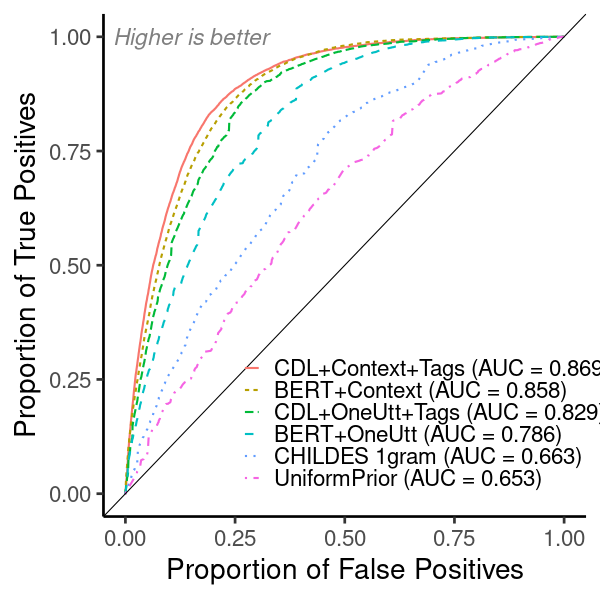

time: 3.13 s (started: 2022-02-14 06:34:38 -08:00)


In [22]:
%%R -h 600 -w 600
p1 = ggplot(filter_model_subset(scores_across_time_short_lev, overview_set), 
       aes(d=set_binarized, m=posterior_entropy, color=model_with_levdist_auc, linetype = model_with_levdist_auc)
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0) + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position=c(.67, .20),
legend.background = element_blank(), legend.title = element_blank()) + annotate("text",
label= "Higher is better", size=8, fontface="italic", x=.15, y=1, alpha =.5) + geom_abline(intercept=0, slope=1)
ggsave('../../output/figures/roc_levdist.pdf', height=12, width=12)    
print(p1)

## WFST

In [23]:
%%R
auc_by_model = do.call('rbind', lapply(unique(subset(scores_across_time_short, likelihood_type == 'WFST')$model), 
      function(model_name){
    one_model = subset(scores_across_time_short, model == model_name & likelihood_type == 'WFST')
    roc1 = roc(one_model$set_binarized, one_model$posterior_entropy)
    return(data.frame(model=model_name, auc_wfst = auc(roc1)))}))

scores_across_time_short_wfst = merge(scores_across_time_short, auc_by_model)


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case =

time: 1min 4s (started: 2022-02-14 06:34:41 -08:00)


In [24]:
%%R

# get rid of tags in the designation
scores_across_time_overview_set = filter_model_subset(scores_across_time_short_wfst, overview_set)
scores_across_time_overview_set$model_shortname = gsub('\\+Tags','', scores_across_time_overview_set$model)

scores_across_time_overview_set$model_shortname_with_wfst_auc = paste0(scores_across_time_overview_set$model_shortname,' (AUC = ',round(scores_across_time_overview_set$auc_wfst, 3),')')

time: 5.11 s (started: 2022-02-14 06:35:45 -08:00)


In [25]:
%%R 
# get the scores associated with each model + a  
names_per_model = aggregate(model_shortname_with_wfst_auc ~ model_shortname, scores_across_time_overview_set, unique)
scores_per_model = aggregate(auc_wfst ~ model_shortname,scores_across_time_overview_set, unique)
scores_per_model = merge(names_per_model, scores_per_model)
scores_per_model = scores_per_model[order(scores_per_model$auc_wfst, decreasing=T),]
print(scores_per_model)

scores_across_time_overview_set$model_shortname_with_wfst_auc = factor(as.character(scores_across_time_overview_set$model_shortname_with_wfst_auc), levels = as.character(scores_per_model$model_shortname_with_wfst_auc))

  model_shortname model_shortname_with_wfst_auc  auc_wfst
3     CDL+Context     CDL+Context (AUC = 0.915) 0.9147973
1    BERT+Context    BERT+Context (AUC = 0.903) 0.9025264
4      CDL+OneUtt      CDL+OneUtt (AUC = 0.893) 0.8926886
2     BERT+OneUtt     BERT+OneUtt (AUC = 0.846) 0.8456843
5   CHILDES 1gram   CHILDES 1gram (AUC = 0.755) 0.7554012
6    UniformPrior    UniformPrior (AUC = 0.628) 0.6275376
time: 3.18 s (started: 2022-02-14 06:35:51 -08:00)


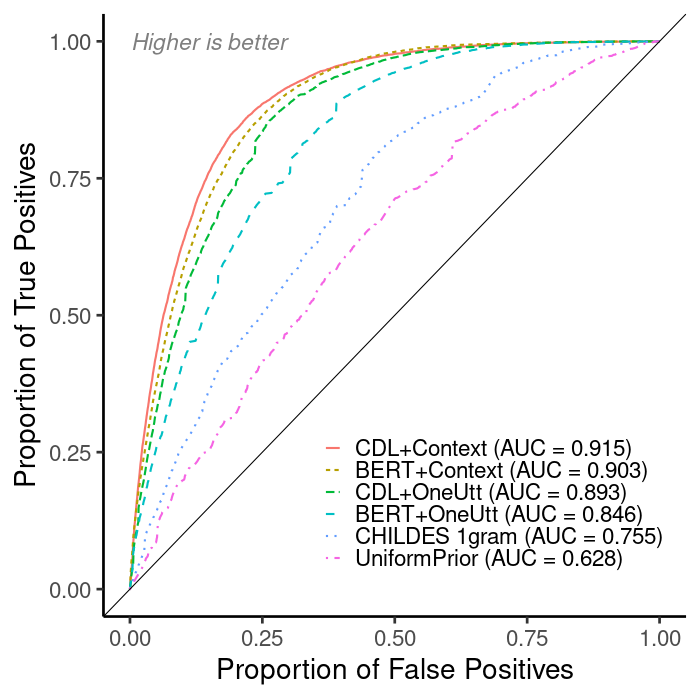

time: 2.92 s (started: 2022-02-14 06:35:54 -08:00)


In [26]:
%%R -h 700 -w 700
p1 = ggplot(scores_across_time_overview_set, 
       aes(d=set_binarized, m=posterior_entropy, color=model_shortname_with_wfst_auc, linetype = model_shortname_with_wfst_auc)
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0) + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position=c(.67, .20),
legend.background = element_blank(), legend.title = element_blank()) + annotate("text",
label= "Higher is better", size=8, fontface="italic", x=.15, y=1, alpha =.5) + geom_abline(intercept=0, slope=1)
print(p1)
ggsave('../../output/figures/roc_likelihoods.pdf', height=10, width=10)    

### Set Color Standards for All Plots

In [27]:
%%R
g <- ggplot_build(p1)
colors_for_6_plots = unique(g$data[[1]]$colour)
colors_for_6_plots

[1] "#F8766D" "#B79F00" "#00BA38" "#00BFC4" "#619CFF" "#F564E3"
time: 1.26 s (started: 2022-02-14 06:35:57 -08:00)


In [28]:
%%R
models_for_6_plots = scores_per_model$model_shortname
as.character(models_for_6_plots)

[1] "CDL+Context"   "BERT+Context"  "CDL+OneUtt"    "BERT+OneUtt"  
[5] "CHILDES 1gram" "UniformPrior" 
time: 12.9 ms (started: 2022-02-14 06:35:58 -08:00)


## Visualization of Exemplars

In [29]:
%%R
unique(as.character(scores_across_time_short$model))

 [1] "BERT+OneUtt"              "BERT+Context"            
 [3] "CDL+OneUtt+Tags"          "CDL+Context+Tags"        
 [5] "CDL+OneUtt"               "CDL+Context"             
 [7] "CDL+Younger+OneUtt+Tags"  "CDL+Younger+Context+Tags"
 [9] "CDL+Younger+OneUtt"       "CDL+Younger+Context"     
[11] "CDL+Older+OneUtt+Tags"    "CDL+Older+Context+Tags"  
[13] "CDL+Older+OneUtt"         "CDL+Older+Context"       
[15] "UniformPrior"             "CHILDES 1gram"           
time: 65.9 ms (started: 2022-02-14 06:35:58 -08:00)


In [30]:
%%R
names(scores_across_time_short)

 [1] "posterior_probability" "posterior_entropy"     "prior_probability"    
 [4] "prior_entropy"         "kl_flat_to_prior"      "kl_flat_to_posterior" 
 [7] "model"                 "set"                   "age"                  
[10] "token"                 "bert_token_id"         "edit_distance"        
[13] "likelihood_type"       "prior_rank"            "posterior_rank"       
[16] "set_binarized"        
time: 24.9 ms (started: 2022-02-14 06:35:58 -08:00)


In [31]:
%%R
index_cols = c('bert_token_id', 'set')
selected_cols = c('posterior_entropy', 'posterior_probability', 'posterior_rank', 'prior_entropy', 'prior_probability', 'prior_rank')
best_model = subset(scores_across_time_short, model == "CDL+Context+Tags" & likelihood_type == 'WFST')[,c(index_cols,selected_cols)]
names(best_model) = c(index_cols, paste0('bert_', selected_cols))
base_model = subset(scores_across_time_short, model == "UniformPrior" & likelihood_type == 'WFST')[,c(index_cols,selected_cols)]
names(base_model) = c(index_cols, paste0('uniform_', selected_cols))
model_scores_merged = merge(best_model, base_model)

time: 1.42 s (started: 2022-02-14 06:35:58 -08:00)


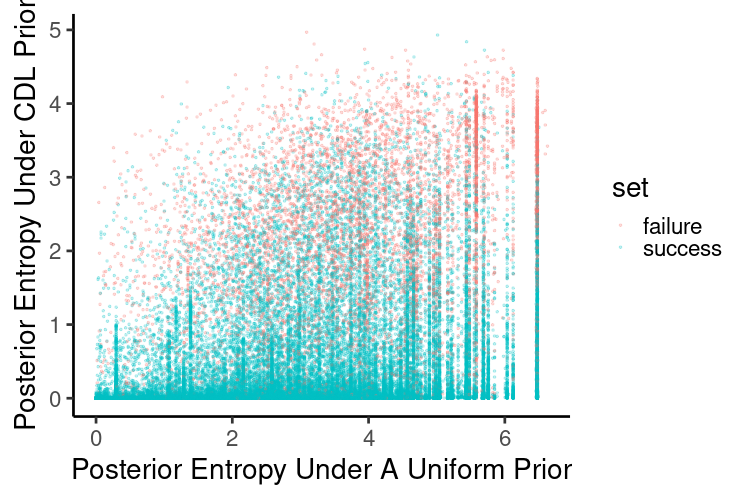

time: 891 ms (started: 2022-02-14 06:35:59 -08:00)


In [32]:
%%R -w 750 -h 500 
ggplot(model_scores_merged) + geom_point(aes(x=uniform_posterior_entropy, y=bert_posterior_entropy, color=set), alpha=.25, size=1
) + theme_classic(base_size=28) + xlab('Posterior Entropy Under A Uniform Prior') + ylab('Posterior Entropy Under CDL Prior')

# Analysis 2: Do the models find the same words as adults?

## Priors

In [33]:
%%R
unique(successes_across_time$likelihood_type)

[1] "Levenshtein Distance" "WFST"                
time: 30.4 ms (started: 2022-02-14 06:36:00 -08:00)


### Prior Table

#### WFST

In [34]:
%%R
# note that we don't need to separate the prior computations by the likelihood type-- it's the prior!

prior_probs = aggregate(prior_probability ~ model, successes_across_time, function(x){mean(-1 * log(x, base = 2))})
posterior_probs = aggregate(posterior_probability ~ model, subset(successes_across_time, likelihood_type == 'WFST'), function(x){mean(-1 * log(x, base = 2))})


prior_probs = merge(prior_probs, posterior_probs)
    
prior_probs = prior_probs[order(prior_probs$prior_probability),]
subset(prior_probs, model %in% overview_set)

              model prior_probability posterior_probability
4  CDL+Context+Tags          3.330677             0.6464443
1      BERT+Context          4.620648             1.0644113
10  CDL+OneUtt+Tags          5.066861             1.0963438
2       BERT+OneUtt          7.338912             1.8815163
15    CHILDES 1gram          8.786068             2.2773164
16     UniformPrior         12.965243             4.6082285
time: 930 ms (started: 2022-02-14 06:36:00 -08:00)


In [35]:
%%R
posterior_mean_rankings = aggregate(posterior_rank ~ model, subset(successes_across_time, likelihood_type == 'WFST'), function(x){mean_posterior_rank = mean(x)})
names(posterior_mean_rankings) = c('model', 'mean_posterior_rank')

prior_mean_rankings = aggregate(prior_rank ~ model, successes_across_time, function(x){mean_prior_rank = mean(x)})
names(prior_mean_rankings) = c('model', 'mean_prior_rank')

rankings = merge(prior_mean_rankings, posterior_mean_rankings, by=c('model'))
rankings = rankings[order(rankings$mean_prior_rank),]
subset(rankings, model %in% overview_set)

              model mean_prior_rank mean_posterior_rank
4  CDL+Context+Tags        50.48621            2.457164
10  CDL+OneUtt+Tags       125.69245            6.965835
1      BERT+Context       140.76924            6.176142
15    CHILDES 1gram       313.72412           14.542632
2       BERT+OneUtt       495.14341           17.875139
16     UniformPrior      3998.00000           62.402769
time: 813 ms (started: 2022-02-14 06:36:01 -08:00)


In [36]:
%%R
for_table = subset(merge(prior_probs, rankings, all.x=T), model %in% overview_set)
for_table
for_table$prior_probability = round(for_table$prior_probability, 2)
for_table$posterior_probability = round(for_table$posterior_probability, 2)
for_table$mean_prior_rank = round(for_table$mean_prior_rank, 2)
for_table$mean_posterior_rank = round(for_table$mean_posterior_rank, 2)
for_table = for_table[,c('model','prior_probability','mean_prior_rank','posterior_probability','mean_posterior_rank')]
for_table =  for_table[order(for_table$prior_probability),]
names(for_table) = c('Model', 'Prior Surprisal (bits)', 'Mean Prior Rank', 'Posterior Surprisal (bits)', 'Mean Posterior Rank')
for_table

              Model Prior Surprisal (bits) Mean Prior Rank
4  CDL+Context+Tags                   3.33           50.49
1      BERT+Context                   4.62          140.77
10  CDL+OneUtt+Tags                   5.07          125.69
2       BERT+OneUtt                   7.34          495.14
15    CHILDES 1gram                   8.79          313.72
16     UniformPrior                  12.97         3998.00
   Posterior Surprisal (bits) Mean Posterior Rank
4                        0.65                2.46
1                        1.06                6.18
10                       1.10                6.97
2                        1.88               17.88
15                       2.28               14.54
16                       4.61               62.40
time: 54.7 ms (started: 2022-02-14 06:36:02 -08:00)


In [37]:
%%R
write.csv(for_table, '../../output/csv/surprisal_table.csv', row.names=F)

time: 9.4 ms (started: 2022-02-14 06:36:02 -08:00)


#### Levenshtein Distance

In [38]:
%%R
prior_probs = aggregate(prior_probability ~ model, successes_across_time, function(x){mean(-1 * log(x, base = 2))})
posterior_probs = aggregate(posterior_probability ~ model, subset(successes_across_time, likelihood_type == 'Levenshtein Distance'), function(x){mean(-1 * log(x, base = 2))})


prior_probs = merge(prior_probs, posterior_probs)
    
prior_probs = prior_probs[order(prior_probs$prior_probability),]
subset(prior_probs, model %in% overview_set)

              model prior_probability posterior_probability
4  CDL+Context+Tags          3.330677              1.183490
1      BERT+Context          4.620648              1.719009
10  CDL+OneUtt+Tags          5.066861              1.965825
2       BERT+OneUtt          7.338912              2.884170
15    CHILDES 1gram          8.786068              3.841817
16     UniformPrior         12.965243              5.059256
time: 913 ms (started: 2022-02-14 06:36:02 -08:00)


In [39]:
%%R
posterior_mean_rankings = aggregate(posterior_rank ~ model, subset(successes_across_time, likelihood_type == 'Levenshtein Distance'), function(x){mean_posterior_rank = mean(x)})
names(posterior_mean_rankings) = c('model', 'mean_posterior_rank')

prior_mean_rankings = aggregate(prior_rank ~ model, successes_across_time, function(x){mean_prior_rank = mean(x)})
names(prior_mean_rankings) = c('model', 'mean_prior_rank')

rankings = merge(prior_mean_rankings, posterior_mean_rankings, by=c('model'))
rankings = rankings[order(rankings$mean_prior_rank),]
subset(rankings, model %in% overview_set)

              model mean_prior_rank mean_posterior_rank
4  CDL+Context+Tags        50.48621             8.15016
10  CDL+OneUtt+Tags       125.69245            25.51499
1      BERT+Context       140.76924            19.10486
15    CHILDES 1gram       313.72412            51.08235
2       BERT+OneUtt       495.14341            48.14005
16     UniformPrior      3998.00000           145.84482
time: 781 ms (started: 2022-02-14 06:36:03 -08:00)


In [40]:
%%R

# 7/15/21 not a code reference, but debugging help:
# https://stackoverflow.com/questions/60083062/tidyrspread-error-each-row-of-output-must-be-identified-by-a-unique-combina
# https://community.rstudio.com/t/spread-error-each-row-of-output-must-be-identified-by-a-unique-combination-of-keys/88325
# https://garrettgman.github.io/tidying

successes_across_time_wide =  spread(successes_across_time[,c('model','prior_probability',
'bert_token_id','likelihood_type')], model, prior_probability)
successes_across_time_wide = subset(successes_across_time_wide, likelihood_type == 'WFST')
head(successes_across_time_wide)

   bert_token_id likelihood_type CDL+Context+Tags  CDL+Context CDL+OneUtt+Tags
2          10577            WFST     7.979536e-07 8.217112e-07    6.114331e-05
4          39428            WFST     5.144511e-04 5.362953e-04    2.304789e-03
6          39594            WFST     6.766981e-01 4.591151e-01    2.304789e-03
8          41265            WFST     5.279500e-01 7.640047e-01    2.071336e-01
10         41266            WFST     3.324036e-01 2.300410e-01    7.424235e-03
12         41756            WFST     5.162919e-05 3.996108e-06    1.043957e-03
     CDL+OneUtt BERT+Context  BERT+OneUtt CDL+Older+Context+Tags
2  0.0001452165 3.667986e-06 6.627159e-05           9.981517e-06
4  0.0020841213 2.478556e-04 1.482733e-04           1.055205e-03
6  0.0020841213 1.482334e-02 1.482733e-04           8.000188e-01
8  0.0415429659 7.339125e-01 2.187229e-02           7.277727e-01
10 0.0043940423 3.372585e-01 3.032029e-04           1.879513e-01
12 0.0003051029 6.015644e-06 3.048955e-06           6.055

In [41]:
%%R

model_names = overview_set
print('Model names:')
print(model_names)

for (model_name in model_names){
    successes_across_time_wide[[model_name]] = as.numeric(successes_across_time_wide[[model_name]])
}

successes_across_time_wide_nona = drop_na(successes_across_time_wide)
print(dim(successes_across_time_wide_nona))

[1] "Model names:"
[1] "CDL+Context+Tags" "BERT+Context"     "CDL+OneUtt+Tags"  "BERT+OneUtt"     
[5] "CHILDES 1gram"    "UniformPrior"    
[1] 43993    18
time: 41 ms (started: 2022-02-14 06:36:05 -08:00)


In [42]:
%%R
unique(successes_across_time_wide_nona$likelihood_type)

[1] "WFST"
time: 10.3 ms (started: 2022-02-14 06:36:05 -08:00)


### t-test Model Comparison

In [43]:
%%R
#Pairwise paired t-test between all of the models with WFST only

rvs = mat.or.vec(length(model_names), length(model_names))

for (model_idx in c(1:length(model_names))){
    for (comparison_model_idx in c(1:length(model_names))){
        if (model_idx == comparison_model_idx){
            rvs[model_idx, comparison_model_idx] = NA
        } else {
            model_name = model_names[model_idx]
            comparison_model_name = model_names[comparison_model_idx]
            rval = t.test(
                successes_across_time_wide_nona[[model_name]], 
                successes_across_time_wide_nona[[comparison_model_name]],
              paired=T)$p.value
            rvs[model_idx, comparison_model_idx] = rval
        }
    }
}
rvs = data.frame(rvs)

rownames(rvs) = model_names
colnames(rvs) = model_names

rvs

                 CDL+Context+Tags BERT+Context CDL+OneUtt+Tags BERT+OneUtt
CDL+Context+Tags               NA            0               0           0
BERT+Context                    0           NA               0           0
CDL+OneUtt+Tags                 0            0              NA           0
BERT+OneUtt                     0            0               0          NA
CHILDES 1gram                   0            0               0           0
UniformPrior                    0            0               0           0
                 CHILDES 1gram UniformPrior
CDL+Context+Tags             0            0
BERT+Context                 0            0
CDL+OneUtt+Tags              0            0
BERT+OneUtt                  0            0
CHILDES 1gram               NA            0
UniformPrior                 0           NA
time: 121 ms (started: 2022-02-14 06:36:05 -08:00)


### Prior Surprisal Across Ages Plots

In [44]:
%R mean_surprisal_by_age = aggregate(prior_probability ~ age + model + likelihood_type, successes_across_time ,\
                function(x){mean(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age) = c('age','model', 'likelihood_type','prior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(prior_probability ~ age + model + likelihood_type, \
        successes_across_time, function(x){sem(-1 * log(x, base = 2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','likelihood_type','prior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 

,age,model,likelihood_type,prior_surprisal_mean,prior_surprisal_sem
1,1.0,BERT+Context,Levenshtein Distance,7.274773,0.115150
2,1.0,BERT+Context,WFST,7.274773,0.115150
3,1.0,BERT+OneUtt,Levenshtein Distance,11.540592,0.109994
4,1.0,BERT+OneUtt,WFST,11.540592,0.109994
5,1.0,CDL+Context,Levenshtein Distance,4.130148,0.109045
...,...,...,...,...,...
188,3.5,CDL+Younger+OneUtt+Tags,WFST,4.558027,0.085502
189,3.5,CHILDES 1gram,Levenshtein Distance,8.952549,0.069915
190,3.5,CHILDES 1gram,WFST,8.952549,0.069915
191,3.5,UniformPrior,Levenshtein Distance,12.965243,0.000000


time: 3.63 s (started: 2022-02-14 06:36:05 -08:00)


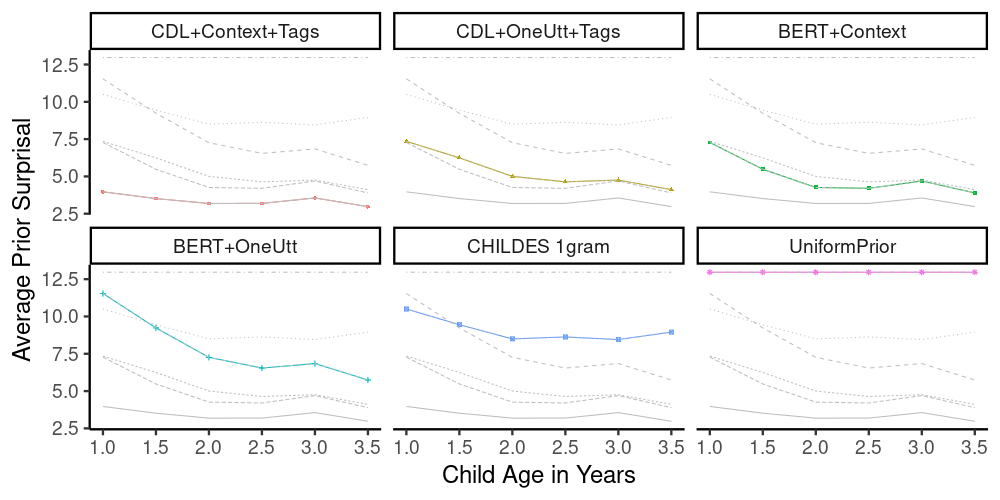

time: 516 ms (started: 2022-02-14 06:36:08 -08:00)


In [45]:
%%R -w 1000 -h 500

overview_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, overview_set)
    
overview_mean_surprisal_for_gray = do.call('rbind', lapply(unique(overview_mean_surprisal_by_age$model), function(model){ get_ref_df(model, overview_mean_surprisal_by_age)}))

ggplot(overview_mean_surprisal_by_age) + geom_point(aes(x=age, y=prior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
    ymax=prior_surprisal_mean + .5*prior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Prior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(~model) + geom_line(data=overview_mean_surprisal_for_gray, aes(x=age,y=prior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')

# # Best performing CDL Context all/all, CHILDES 1gram and Uniform Prior 

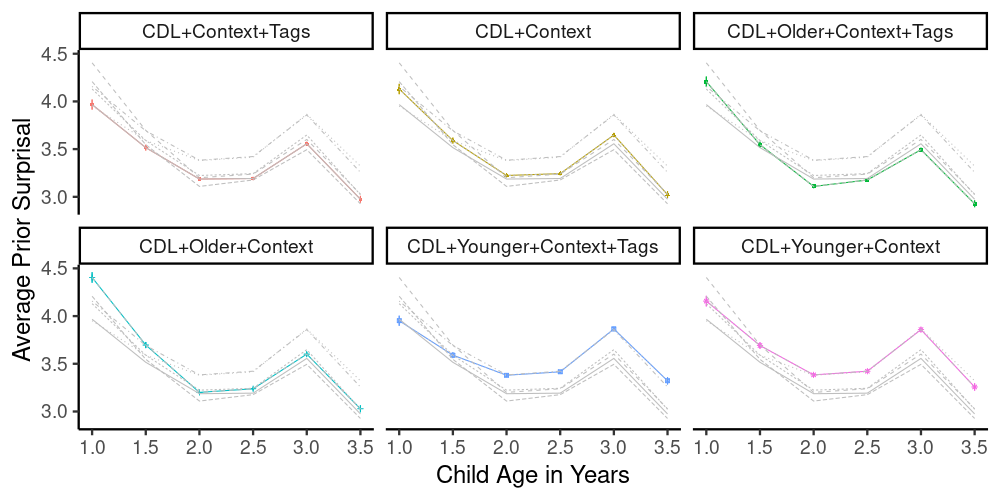

time: 469 ms (started: 2022-02-14 06:36:09 -08:00)


In [46]:
%%R -w 1000 -h 500

subset_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, splits_tags_set)
    
subset_mean_surprisal_for_gray = do.call('rbind', lapply(unique(subset_mean_surprisal_by_age$model), function(model){ get_ref_df(model, subset_mean_surprisal_by_age)}))

ggplot(subset_mean_surprisal_by_age) + geom_point(aes(x=age, y=prior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
    ymax=prior_surprisal_mean + .5*prior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Prior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(~model) + geom_line(data=subset_mean_surprisal_for_gray, aes(x=age,y=prior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')



## Posterior

In [47]:
%R mean_surprisal_by_age = aggregate(posterior_probability ~ age + model + likelihood_type, successes_across_time ,\
                function(x){mean(-1 * log(x, base = 2))})
%R names(mean_surprisal_by_age) = c('age','model','likelihood','posterior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(posterior_probability ~ age + model + likelihood_type, \
        successes_across_time, function(x){sem(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','likelihood','posterior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 
#%R print(mean_surprisal_by_age)

,age,model,likelihood,posterior_surprisal_mean,posterior_surprisal_sem
1,1.0,BERT+Context,Levenshtein Distance,4.345187,0.114305
2,1.0,BERT+Context,WFST,2.791358,0.089477
3,1.0,BERT+OneUtt,Levenshtein Distance,7.309036,0.149313
4,1.0,BERT+OneUtt,WFST,5.122672,0.124067
5,1.0,CDL+Context,Levenshtein Distance,2.359120,0.089852
...,...,...,...,...,...
188,3.5,CDL+Younger+OneUtt+Tags,WFST,0.712743,0.039535
189,3.5,CHILDES 1gram,Levenshtein Distance,3.062582,0.085565
190,3.5,CHILDES 1gram,WFST,1.958813,0.064519
191,3.5,UniformPrior,Levenshtein Distance,3.800962,0.072356


time: 3.78 s (started: 2022-02-14 06:36:09 -08:00)


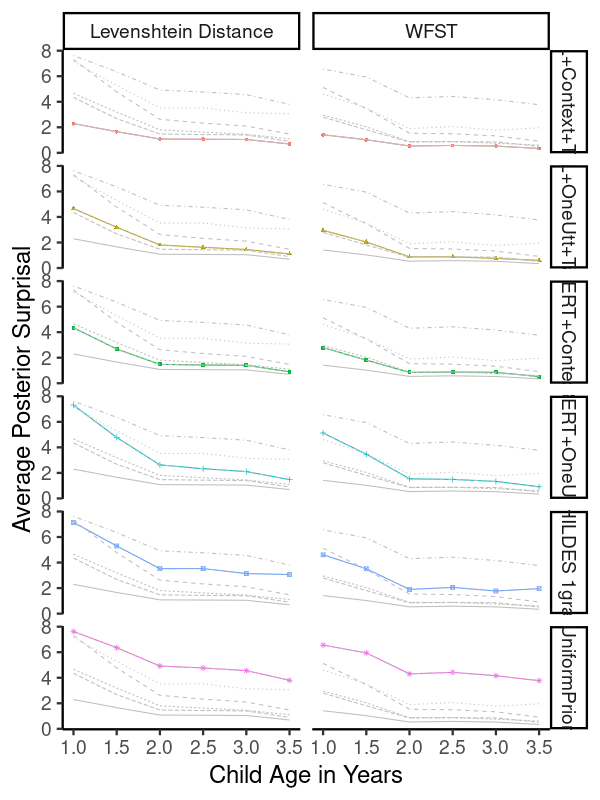

time: 557 ms (started: 2022-02-14 06:36:13 -08:00)


In [48]:
%%R -w 600 -h 800

overview_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, overview_set)
    
overview_mean_surprisal_for_gray = do.call('rbind', lapply(unique(overview_mean_surprisal_by_age$model), function(model){ get_ref_df(model, overview_mean_surprisal_by_age)}))

ggplot(overview_mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
    ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years') +
    facet_grid(model~likelihood) + geom_line(data=overview_mean_surprisal_for_gray, aes(x=age,y=posterior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')


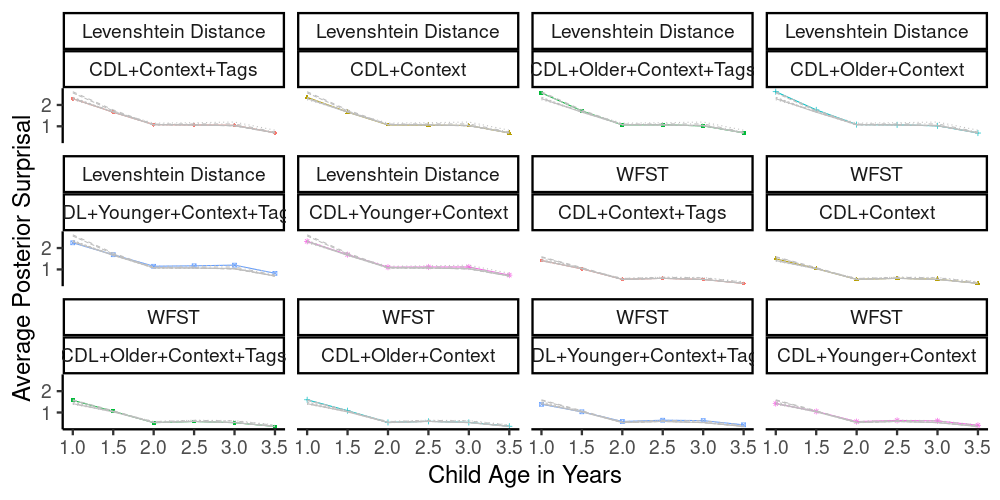

time: 777 ms (started: 2022-02-14 06:36:14 -08:00)


In [49]:
%%R -w 1000 -h 500

subset_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, splits_tags_set)
    
subset_mean_surprisal_for_gray = do.call('rbind', lapply(unique(subset_mean_surprisal_by_age$model), function(model){ get_ref_df(model, subset_mean_surprisal_by_age)}))

ggplot(subset_mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
    ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(likelihood~model) + geom_line(data=subset_mean_surprisal_for_gray, aes(x=age,y=posterior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')


In [50]:
%%R
unique(as.character(mean_surprisal_by_age$model))

 [1] "BERT+Context"             "BERT+OneUtt"             
 [3] "CDL+Context"              "CDL+Context+Tags"        
 [5] "CDL+Older+Context"        "CDL+Older+Context+Tags"  
 [7] "CDL+Older+OneUtt"         "CDL+Older+OneUtt+Tags"   
 [9] "CDL+OneUtt"               "CDL+OneUtt+Tags"         
[11] "CDL+Younger+Context"      "CDL+Younger+Context+Tags"
[13] "CDL+Younger+OneUtt"       "CDL+Younger+OneUtt+Tags" 
[15] "CHILDES 1gram"            "UniformPrior"            
time: 36.9 ms (started: 2022-02-14 06:36:15 -08:00)


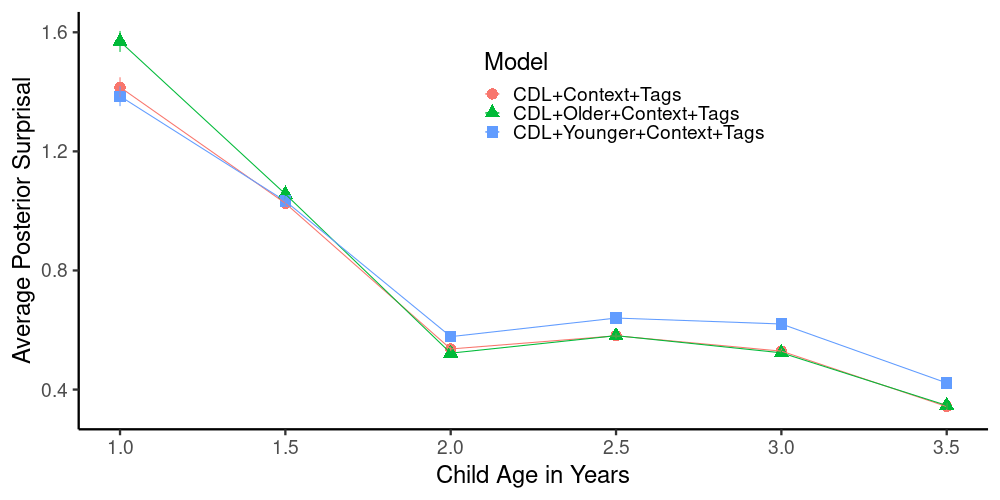

time: 431 ms (started: 2022-02-14 06:36:15 -08:00)


In [51]:
%%R -w 1000 -h 500

selected_models = c('CDL+Younger+Context+Tags', 'CDL+Older+Context+Tags', 'CDL+Context+Tags')

p1 =  ggplot(subset(mean_surprisal_by_age, likelihood == 'WFST' &  model %in% selected_models)
    ) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
    shape = model), size=5) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
    ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years') + theme(
    legend.position=c(.6, .8))  +  guides(shape = guide_legend(title = "Model"), color = guide_legend(title = "Model"))

ggsave('../../output/figures/posterior_surprisal_by_age.pdf', height=6, width=8)
p1

In [52]:
scores_across_time_short.drop_duplicates(subset=['bert_token_id']).set.value_counts()

success    43993
failure     6756
Name: set, dtype: int64

time: 122 ms (started: 2022-02-14 06:36:15 -08:00)


### Posterior Probability by Edit Distance Plot

In [53]:
%%R
# have to do some data rotation to handle the fact that each observation needs both a Levenshtein distance and an edit dsitance
levdists = subset(successes_across_time, likelihood_type == "Levenshtein Distance" & model %in% overview_set)
dim(levdists)
wfsts = subset(successes_across_time, likelihood_type == "WFST" & model %in% overview_set)
dim(wfsts)

[1] 263958     15
time: 250 ms (started: 2022-02-14 06:36:15 -08:00)


In [54]:
%%R
unique(as.character(levdists$model))

[1] "BERT+OneUtt"      "BERT+Context"     "CDL+OneUtt+Tags"  "CDL+Context+Tags"
[5] "UniformPrior"     "CHILDES 1gram"   
time: 21.9 ms (started: 2022-02-14 06:36:15 -08:00)


In [55]:
%%R
wfsts$wfst_distance = wfsts$edit_distance # copy wfst distance into its own column
wfsts$edit_distance = NULL
levdists$wfst_distance = 0 # leave this column unpopulated on levdists

time: 7.77 ms (started: 2022-02-14 06:36:15 -08:00)


In [56]:
%%R
print(dim(wfsts))
print(dim(levdists))

[1] 263958     15
[1] 263958     16
time: 14.2 ms (started: 2022-02-14 06:36:15 -08:00)


In [57]:
%%R
wfsts_merged = merge(wfsts, levdists[,c('bert_token_id','edit_distance')]) # this takes a while

time: 55.2 s (started: 2022-02-14 06:36:15 -08:00)


In [58]:
%%R
levdists[,c('bert_token_id','edit_distance')][1:10,]

     bert_token_id edit_distance
1891       1776009             3
1892       1029904             2
1893       1029905             2
1894        506615             1
1895        506616             2
1896        506620             1
1897        506621             0
1898        940389             0
1899        940390             0
1900        855679             3
time: 36.9 ms (started: 2022-02-14 06:37:11 -08:00)


In [59]:
%%R 
ed = rbind.fill(wfsts_merged, levdists) # this takes a while

time: 1min 1s (started: 2022-02-14 06:37:11 -08:00)


In [60]:
%%R
# confirm that edit distances are integers
unique(ed$edit_distance)

[1] 3 0 1 2 5 4 6 7 8
time: 42.5 ms (started: 2022-02-14 06:38:13 -08:00)


In [61]:
%%R
surprisal_by_edit_distance = aggregate(posterior_probability ~ edit_distance + model + likelihood_type, ed, 
    function(x){mean(-1 * log(x, base = 2))})
names(surprisal_by_edit_distance) = c('edit_distance', 'model', 'likelihood_type', 'mean_posterior_surprisal')
sem <- function(x) sd(x)/sqrt(length(x))
surprisal_by_edit_distance_sem = aggregate(posterior_probability ~ edit_distance + model + likelihood_type, ed, 
    function(x){sem(-1 * log(x, base = 2))})
names(surprisal_by_edit_distance_sem) = c('edit_distance','model','likelihood_type','mean_posterior_surprisal_sem')
surprisal_by_edit_distance = merge(surprisal_by_edit_distance, surprisal_by_edit_distance_sem)
surprisal_by_edit_distance$high = surprisal_by_edit_distance$mean_posterior_surprisal + surprisal_by_edit_distance$mean_posterior_surprisal_sem 
surprisal_by_edit_distance$low = surprisal_by_edit_distance$mean_posterior_surprisal - surprisal_by_edit_distance$mean_posterior_surprisal_sem


time: 4.75 s (started: 2022-02-14 06:38:13 -08:00)


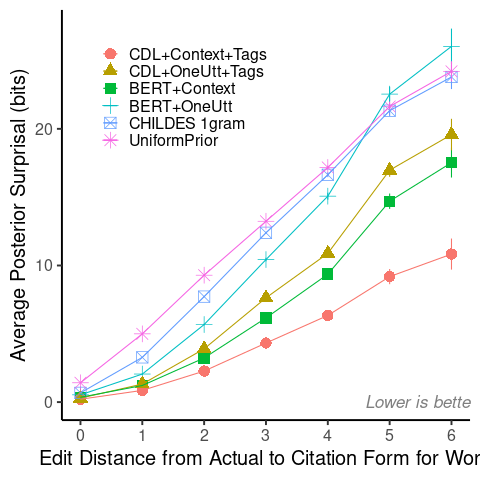

time: 472 ms (started: 2022-02-14 06:38:17 -08:00)


In [62]:
%%R

surprisal_by_edit_distance_for_plot = subset(surprisal_by_edit_distance, likelihood_type != 'WFST' & edit_distance <= 6)

surprisal_for_gray = do.call('rbind', lapply(unique(surprisal_by_edit_distance_for_plot$model), function(model){ get_ref_df(model, surprisal_by_edit_distance_for_plot)}))

p1= ggplot(surprisal_by_edit_distance_for_plot) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model), width=0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model, 
shape=model)) + theme(legend.position=c(.3, .8), legend.background=element_blank(), legend.title = element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic")  + scale_x_continuous(breaks=c(0:6), labels = c(0:6))

ggsave('../../output/figures/multiplier_by_edit_distance.pdf', height=6, width=8)    
print(p1)

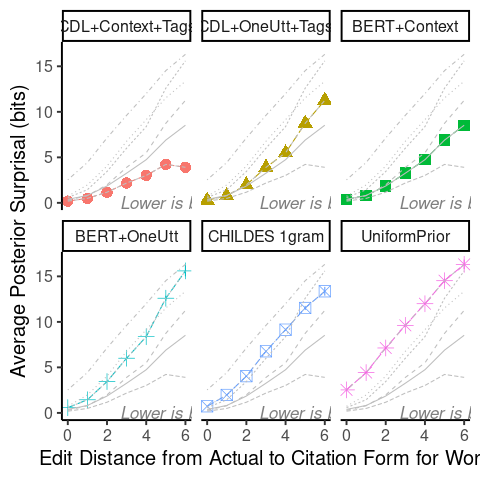

time: 445 ms (started: 2022-02-14 06:38:18 -08:00)


In [63]:
%%R
surprisal_by_edit_distance_for_plot = subset(surprisal_by_edit_distance, likelihood_type == 'WFST' & edit_distance <= 6)

surprisal_for_gray = do.call('rbind', lapply(unique(surprisal_by_edit_distance_for_plot$model), function(model){ get_ref_df(model, surprisal_by_edit_distance_for_plot)}))

p1= ggplot(surprisal_by_edit_distance_for_plot) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model), width = 0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model, 
shape=model, linetype=likelihood_type)) + theme(legend.position=c(.3, .8), legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic") +
facet_wrap(~model) + geom_line(data=surprisal_for_gray, aes(x=edit_distance,y=mean_posterior_surprisal, linetype = line_model),colour='gray', alpha=1)+
theme(legend.position='none')
print(p1)

#### Levenshtein Distance

In [64]:
%%R
# Multiplier for each 
unigram_prior = subset(surprisal_by_edit_distance, model == "UniformPrior" & likelihood_type == 'Levenshtein Distance')[,c('edit_distance',
    'mean_posterior_surprisal')]
names(unigram_prior)[2] = "unigram_prior_prob"

surprisal_by_edit_distance_lev = merge(subset(surprisal_by_edit_distance, likelihood_type == 'Levenshtein Distance'), unigram_prior)
surprisal_by_edit_distance_lev$multiplier = 2^( surprisal_by_edit_distance_lev$unigram_prior_prob -
    surprisal_by_edit_distance_lev$mean_posterior_surprisal)

head(surprisal_by_edit_distance_lev, n=10)


   edit_distance            model      likelihood_type mean_posterior_surprisal
1              0     BERT+Context Levenshtein Distance                0.3562092
2              0      BERT+OneUtt Levenshtein Distance                0.5353647
3              0 CDL+Context+Tags Levenshtein Distance                0.2120225
4              0  CDL+OneUtt+Tags Levenshtein Distance                0.2940632
5              0    CHILDES 1gram Levenshtein Distance                0.6774828
6              0     UniformPrior Levenshtein Distance                1.4167799
7              1     BERT+Context Levenshtein Distance                1.2194031
8              1      BERT+OneUtt Levenshtein Distance                2.0544969
9              1 CDL+Context+Tags Levenshtein Distance                0.8613976
10             1  CDL+OneUtt+Tags Levenshtein Distance                1.3230347
   mean_posterior_surprisal_sem      high       low unigram_prior_prob
1                   0.008921247 0.3651305 0.34728

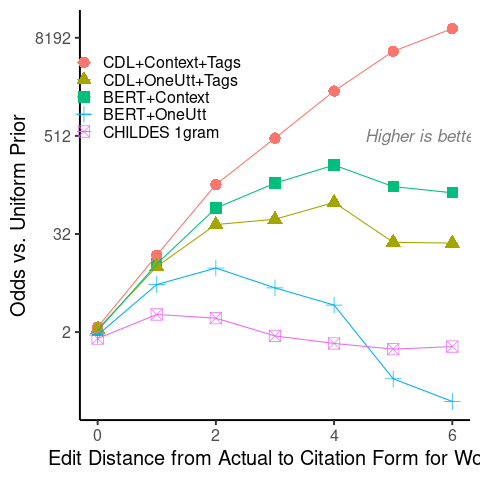

time: 409 ms (started: 2022-02-14 06:38:18 -08:00)


In [65]:
%%R

# Added: no subsetting for the odds uniform prior

p2= ggplot(subset(surprisal_by_edit_distance_lev, edit_distance <= 6 & model %in% overview_set 
& likelihood_type =='Levenshtein Distance' & model != 'UniformPrior')) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.2, .8), 
    legend.background=element_blank(), legend.title = element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=512, alpha=.5, size=6, fontface ="italic") + scale_y_continuous(trans='log2')
ggsave('../../output/figures/multiplier_by_edit_dstance_log_scale_all.pdf', height=6, width=8)    
print(p2)

#### WFST

In [66]:
%%R
# make sure it uses the same colors
surprisal_by_edit_distance_for_plot = subset(surprisal_by_edit_distance, likelihood_type == 'WFST' & edit_distance <= 6)
surprisal_by_edit_distance_for_plot$model_shortname= gsub('\\+Tags','',surprisal_by_edit_distance_for_plot$model)
surprisal_by_edit_distance_for_plot$model_shortname = factor(surprisal_by_edit_distance_for_plot$model_shortname, levels = models_for_6_plots)



time: 4.56 ms (started: 2022-02-14 06:38:19 -08:00)


In [67]:
%%R
as.character(surprisal_by_edit_distance_for_plot$model_shortname)

 [1] "BERT+Context"  "BERT+OneUtt"   "CDL+Context"   "CDL+OneUtt"   
 [5] "CHILDES 1gram" "UniformPrior"  "BERT+Context"  "BERT+OneUtt"  
 [9] "CDL+Context"   "CDL+OneUtt"    "CHILDES 1gram" "UniformPrior" 
[13] "BERT+Context"  "BERT+OneUtt"   "CDL+Context"   "CDL+OneUtt"   
[17] "CHILDES 1gram" "UniformPrior"  "BERT+Context"  "BERT+OneUtt"  
[21] "CDL+Context"   "CDL+OneUtt"    "CHILDES 1gram" "UniformPrior" 
[25] "BERT+Context"  "BERT+OneUtt"   "CDL+Context"   "CDL+OneUtt"   
[29] "CHILDES 1gram" "UniformPrior"  "BERT+Context"  "BERT+OneUtt"  
[33] "CDL+Context"   "CDL+OneUtt"    "CHILDES 1gram" "UniformPrior" 
[37] "BERT+Context"  "BERT+OneUtt"   "CDL+Context"   "CDL+OneUtt"   
[41] "CHILDES 1gram" "UniformPrior" 
time: 62.5 ms (started: 2022-02-14 06:38:19 -08:00)


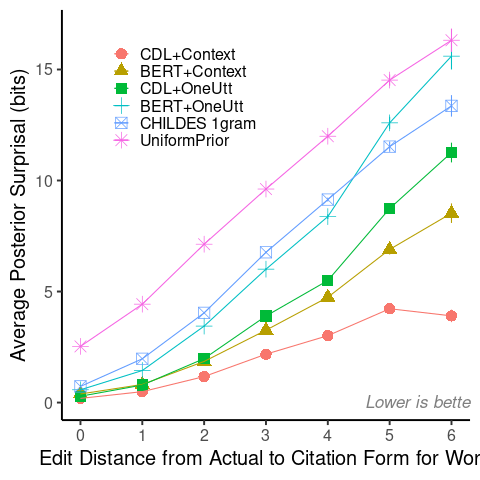

time: 506 ms (started: 2022-02-14 06:38:19 -08:00)


In [68]:
%%R

p1= ggplot(surprisal_by_edit_distance_for_plot) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model_shortname, shape=model_shortname), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model_shortname), width=0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model_shortname, 
shape=model_shortname)) + theme(legend.position=c(.3, .8), legend.background=element_blank(), legend.title = element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic")  + scale_x_continuous(breaks=c(0:6), labels = c(0:6))

ggsave('../../output/figures/surpsisal_by_edit_distance_likelihoods.pdf', height=6, width=8)    
print(p1)

### Proportion Agreeing with Annotator

%%R
proportion_retrieved = aggregate(prior_rank ~ model + likelihood_type, successes_across_time, function(x){mean(x < 5)})
proportion_retrieved

In [72]:
%%R
proportion_retrieved = aggregate(posterior_rank ~ model + likelihood_type, successes_across_time, function(x){mean(x == 0)})
proportion_retrieved

                      model      likelihood_type posterior_rank
1          CDL+Context+Tags Levenshtein Distance      0.8208351
2               CDL+Context Levenshtein Distance      0.8228809
3           CDL+OneUtt+Tags Levenshtein Distance      0.7308890
4                CDL+OneUtt Levenshtein Distance      0.7261837
5              BERT+Context Levenshtein Distance      0.7601209
6               BERT+OneUtt Levenshtein Distance      0.6576955
7    CDL+Older+Context+Tags Levenshtein Distance      0.8198350
8         CDL+Older+Context Levenshtein Distance      0.8198577
9          CDL+Older+OneUtt Levenshtein Distance      0.7304571
10    CDL+Older+OneUtt+Tags Levenshtein Distance      0.7309572
11 CDL+Younger+Context+Tags Levenshtein Distance      0.8081740
12      CDL+Younger+Context Levenshtein Distance      0.8156752
13  CDL+Younger+OneUtt+Tags Levenshtein Distance      0.7054077
14       CDL+Younger+OneUtt Levenshtein Distance      0.7119314
15            CHILDES 1gram Levenshtein 

### Proportion Agreeing with Annotator Per Age

In [73]:
%%R
names(successes_across_time)

 [1] "posterior_probability" "posterior_entropy"     "prior_probability"    
 [4] "prior_entropy"         "kl_flat_to_prior"      "kl_flat_to_posterior" 
 [7] "model"                 "set"                   "age"                  
[10] "token"                 "bert_token_id"         "edit_distance"        
[13] "likelihood_type"       "prior_rank"            "posterior_rank"       
time: 19.2 ms (started: 2022-02-14 06:38:21 -08:00)


In [74]:
%%R
proportion_retrieved = aggregate(posterior_rank ~ model + age + likelihood_type, successes_across_time, function(x){mean(x == 0)})

time: 1.79 s (started: 2022-02-14 06:38:21 -08:00)


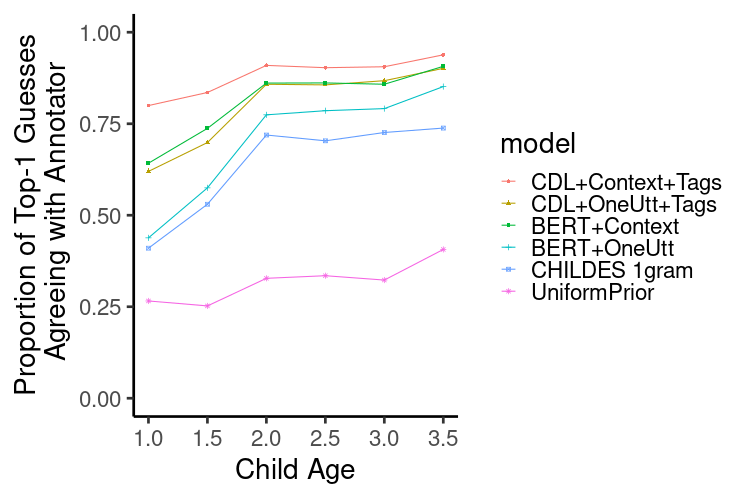

time: 191 ms (started: 2022-02-14 06:38:23 -08:00)


In [75]:
%%R -w 750 -h 500
ggplot(filter_model_subset(subset(proportion_retrieved, likelihood_type == 'WFST'), overview_set)) + geom_line(aes(x=age, y=posterior_rank, color=model)
) + geom_point(aes(x=age, y=posterior_rank, color=model, shape=model)) + coord_cartesian(ylim=c(0,1)) + xlab('Child Age') + ylab(
    'Proportion of Top-1 Guesses\n Agreeing with Annotator') + theme_classic(base_size=28) + theme(legend.background = element_blank())




# Discussion: Child-Specific Analyses

In [76]:
from src.utils import load_splits
all_tokens_phono = load_splits.load_phono()
all_tokens_phono_short = all_tokens_phono[['bert_token_id','target_child_name']]
%R -i all_tokens_phono_short

time: 1min 10s (started: 2022-02-14 06:38:23 -08:00)


In [77]:
%%R
successes_across_time_with_child_label = merge(successes_across_time, all_tokens_phono_short)

time: 58.6 s (started: 2022-02-14 06:39:34 -08:00)


In [78]:
%%R
names(successes_across_time_with_child_label)

 [1] "bert_token_id"         "posterior_probability" "posterior_entropy"    
 [4] "prior_probability"     "prior_entropy"         "kl_flat_to_prior"     
 [7] "kl_flat_to_posterior"  "model"                 "set"                  
[10] "age"                   "token"                 "edit_distance"        
[13] "likelihood_type"       "prior_rank"            "posterior_rank"       
[16] "target_child_name"    
time: 33.6 ms (started: 2022-02-14 06:40:32 -08:00)


In [79]:
%%R
posterior_entropy_by_child = aggregate(posterior_entropy ~ model + likelihood_type + target_child_name, successes_across_time_with_child_label, mean)
subset(posterior_entropy_by_child, likelihood_type == 'WFST' & model == 'CDL+Context+Tags')

               model likelihood_type target_child_name posterior_entropy
17  CDL+Context+Tags            WFST              Alex         0.4850162
49  CDL+Context+Tags            WFST             Ethan         0.5900796
81  CDL+Context+Tags            WFST              Lily         0.2838924
113 CDL+Context+Tags            WFST             Naima         0.3600090
145 CDL+Context+Tags            WFST            Violet         0.3905320
177 CDL+Context+Tags            WFST           William         0.4711304
time: 955 ms (started: 2022-02-14 06:40:32 -08:00)


In [80]:
%%R
proportion_retrieved = aggregate(prior_probability ~ model  + likelihood_type + target_child_name, successes_across_time_with_child_label, function(x){mean(-1 *log(x, base=2))})
subset(proportion_retrieved, likelihood_type == 'WFST' & model == 'CDL+Context+Tags')

               model likelihood_type target_child_name prior_probability
17  CDL+Context+Tags            WFST              Alex          4.016616
49  CDL+Context+Tags            WFST             Ethan          3.340438
81  CDL+Context+Tags            WFST              Lily          3.009920
113 CDL+Context+Tags            WFST             Naima          3.197227
145 CDL+Context+Tags            WFST            Violet          3.203181
177 CDL+Context+Tags            WFST           William          3.449705
time: 1.07 s (started: 2022-02-14 06:40:33 -08:00)


In [81]:
%%R
proportion_retrieved = aggregate(posterior_rank ~ model  + likelihood_type + target_child_name, successes_across_time_with_child_label, function(x){mean(x == 0)})
names(proportion_retrieved)[4] = 'proportion_top_1'
subset(proportion_retrieved, likelihood_type == 'WFST' & model == 'CDL+Context+Tags')


               model likelihood_type target_child_name proportion_top_1
17  CDL+Context+Tags            WFST              Alex        0.8714394
49  CDL+Context+Tags            WFST             Ethan        0.8211613
81  CDL+Context+Tags            WFST              Lily        0.9293833
113 CDL+Context+Tags            WFST             Naima        0.9006317
145 CDL+Context+Tags            WFST            Violet        0.8918855
177 CDL+Context+Tags            WFST           William        0.8734289
time: 908 ms (started: 2022-02-14 06:40:34 -08:00)


In [82]:
%%R
proportion_retrieved = aggregate(prior_rank ~ model  + likelihood_type + target_child_name, successes_across_time_with_child_label, function(x){mean(x == 0)})
names(proportion_retrieved)[4] = 'proportion_top_1'
subset(proportion_retrieved, likelihood_type == 'WFST' & model == 'CDL+Context+Tags')



               model likelihood_type target_child_name proportion_top_1
17  CDL+Context+Tags            WFST              Alex        0.4766826
49  CDL+Context+Tags            WFST             Ethan        0.5801290
81  CDL+Context+Tags            WFST              Lily        0.5669935
113 CDL+Context+Tags            WFST             Naima        0.5809038
145 CDL+Context+Tags            WFST            Violet        0.5524012
177 CDL+Context+Tags            WFST           William        0.5423969
time: 917 ms (started: 2022-02-14 06:40:35 -08:00)
